<a href="https://colab.research.google.com/github/anoushkadas/AnoushkaDas/blob/main/Reimplementation_of_CNN%E2%80%99s_for_Insect_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import math
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import copy
import os


In [ ]:
!unzip data2.zip

unzip:  cannot find or open data2.zip, data2.zip.zip or data2.zip.ZIP.


setup the dataloader, the dataloader will pull directly from the folder assigning labels based on folder name

In [ ]:
#Resizes image to 224 x 224

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Loading the Kaggle dataset
dataset = datasets.ImageFolder('/content/New folder/archive', transform=transform)

# Split into train/test (80/20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
#Takes 128 images, and updates the weights
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
print(f"Classes: {dataset.classes}")  # Folder names in alphabetical order
print(f"Class to index: {dataset.class_to_idx}") #show what class is what index
print(f"Total images: {len(dataset)}")

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Classes: ['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']
Class to index: {'Butterfly': 0, 'Dragonfly': 1, 'Grasshopper': 2, 'Ladybird': 3, 'Mosquito': 4}
Total images: 4449
Train: 3559, Test: 890


download the model with all the weights

In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False #freeze the weights for the big layers/conv layers

# Replace the classifier with new layers including BatchNorm and Dropout
model.classifier = nn.Sequential(
    #when it gets to the later VGG layer it is 7x7, therefore 512 feature maps and x7x7
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.BatchNorm1d(4096), # Added Batch Normalization
    nn.Dropout(p=0.5),

    #Refining features here
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.BatchNorm1d(4096), # Added Batch Normalization
    nn.Dropout(p=0.5),

    nn.Linear(4096, 5) # Final layer for 5 classes
)

# Ensure the new classifier layers are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# Move to GPU if available, helps with matrix multiplication, Cuda means GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Train the model with adam

In [ ]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) #train just the last layers model.classifier.parameters()

# Training loop
num_epochs = 20
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics, setting variables to do math later
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Training complete!')

Epoch [1/12], Loss: 0.8496, Accuracy: 73.50%
Epoch [2/12], Loss: 0.2483, Accuracy: 92.67%
Epoch [3/12], Loss: 0.1618, Accuracy: 95.79%
Epoch [4/12], Loss: 0.1122, Accuracy: 97.56%
Epoch [5/12], Loss: 0.1017, Accuracy: 97.72%
Epoch [6/12], Loss: 0.1529, Accuracy: 98.15%
Epoch [7/12], Loss: 0.0976, Accuracy: 98.23%
Epoch [8/12], Loss: 0.2740, Accuracy: 97.61%
Epoch [9/12], Loss: 0.3040, Accuracy: 96.63%
Epoch [10/12], Loss: 0.2215, Accuracy: 98.06%
Epoch [11/12], Loss: 0.1961, Accuracy: 98.15%


evaluate the model on the testing data



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical') # Added xticks_rotation here
plt.title('Confusion Matrix')
plt.savefig("matrix.png")
plt.show()

Test Accuracy: 92.70%


Test the model on unseen data

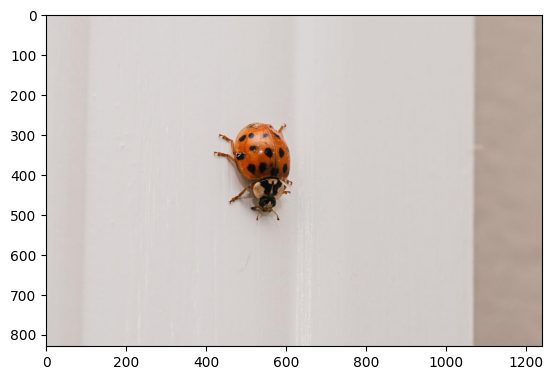

Predicted class: 3
Output logits: tensor([-52.2274, -63.5721, -93.2776, 132.5249, -80.2194], device='cuda:0')


In [ ]:
from PIL import Image
import torch
from torchvision import transforms
# image_link-   https://s.yimg.com/ny/api/res/1.2/1Wc.yYsI_PsIfdoKWeClFg--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyNDI7aD04Mjk-/https://media.zenfs.com/en/aol_martha_stewart_living_articles_160/f2b8fe9eb35030ef33fd6d0c7a80eb9f
# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open('imd.jpg')
#display the img
plt.imshow(img)
plt.show()
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Move to device and run inference
model.eval()
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

print(f'Predicted class: {predicted.item()}')
print(f'Output logits: {output[0]}')

Visualize Predictions

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

model.eval()
correct = 0
total = 0

all_images = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_images.extend(images.cpu().numpy())
        all_labels.extend(labels.cpu().tolist())
        all_predictions.extend(predicted.cpu().tolist())

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Denormalization parameters (from the transform definition)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """Denormalize image tensor to display correctly."""
    # If tensor is (C, H, W) and numpy, we need to transpose to (H, W, C) before denormalization
    # Then denormalize
    img_np = tensor.transpose((1, 2, 0)) # C, H, W to H, W, C
    img_np = STD * img_np + MEAN
    img_np = np.clip(img_np, 0, 1) # Clip values to [0, 1]
    return img_np

def display_image_with_prediction(index):
    img_tensor = all_images[index]
    true_label_idx = all_labels[index]
    predicted_label_idx = all_predictions[index]

    # Denormalize and transpose for display
    img_to_display = denormalize(img_tensor)

    true_label_name = dataset.classes[true_label_idx]
    predicted_label_name = dataset.classes[predicted_label_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_to_display)
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.axis('off')
    plt.show()

# Create a slider widget
image_slider = widgets.IntSlider(
    min=0,
    max=len(all_images) - 1,
    step=1,
    description='Image Index:',
    continuous_update=False
)

# Use widgets.interact to link the slider to the display function
widgets.interact(display_image_with_prediction, index=image_slider);

Test Accuracy: 92.70%


interactive(children=(IntSlider(value=0, continuous_update=False, description='Image Index:', max=889), Output…